In [ ]:
# !pip install nltk matplotlib seaborn pandas scikit-learn numpy

In [ ]:
import os
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re

nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# tokenize.word_tokenize("Hello my name is Test name!")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# REMINDER DON'T REMOVE THIS BLOCK!!!
# Needed for reviewing how we parsed data into a csv

In [ ]:
# def parse_newsgroup_post(filepath):
#     try:
#         data = {}
#         with open(filepath, 'r', encoding='latin1') as f:
#             lines = f.readlines()
#
#         header_lines = []
#         text_lines = []
#         in_text = False
#
#         for line in lines:
#             stripped = line.strip()
#             if in_text:
#                 text_lines.append(line.rstrip('\n'))
#             else:
#                 match = re.match(r'^([\w\-]+):\s+(.*)', stripped)
#                 if match:
#                     key, value = match.groups()
#                     data[key] = value
#                     if key.lower() == 'lines':
#                         in_text = True
#
#         data['Text'] = ' '.join(text_lines).strip()
#         return data
#
#     except Exception as e:
#         print(f"Error parsing {filepath}: {e}")
#         return None
#
# def load_20newsgroups_df(directory):
#     data = []
#     for root, _, files in os.walk(directory):
#         for file in files:
#             path = os.path.join(root, file)
#             parsed = parse_newsgroup_post(path)
#             if parsed:
#               group_name = os.path.basename(root)
#               parsed['group_name'] = group_name
#               data.append(parsed)
#     return pd.DataFrame(data)
#
# def directory_path(train_or_test: str):
#     directory_path = f"./20news-bydate-{train_or_test}"
#     return directory_path
#
# df = load_20newsgroups_df(directory_path("test"))
# df.to_csv('news-test-dataset.csv')

# Show some data
train_df, test_df = pd.read_csv('drive/MyDrive/news-train-dataset.csv'), pd.read_csv('drive/MyDrive/news-test-dataset.csv')


<ipython-input-6-8193edd720b9>:50: DtypeWarning: Columns (5,9,28,30,31,32,33,34,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,56,60,61,62,63,64,66,67,68,69,71,72,75,76,77,78,79,80,81,82,83,84,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df, test_df = pd.read_csv('drive/MyDrive/news-train-dataset.csv'), pd.read_csv('drive/MyDrive/news-test-dataset.csv')


In [ ]:
def overview_column_info(df: pd.DataFrame, column: str, sample_size: int = 5):
    """
    Gathers info for a specific column.
    """
    col_series = df[column]
    duplicates_count = col_series.duplicated().sum()
    type = col_series.dtype
    null_count = col_series.isnull().sum()
    unique_vals = col_series.dropna().unique()
    num_unique = len(unique_vals)
    sample_vals = unique_vals[:sample_size]

    return {
        "Column": column,
        "Type": type,
        "Duplicates Count": duplicates_count,
        "Null Count": null_count,
        "Unique Count": num_unique,
        "Sample Unique Values": ", ".join(map(str, sample_vals))
    }

def overview_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a summary DataFrame containing overview info about all columns.
    """
    rows, cols = df.shape
    print(f"DataFrame Shape -> Rows: {rows}, Columns: {cols}\n")

    column_summaries = []
    for col in df.columns:
        info = overview_column_info(df, col)
        column_summaries.append(info)

    summary_df = pd.DataFrame(column_summaries)
    return summary_df

overview_df(train_df)

DataFrame Shape -> Rows: 11314, Columns: 87



,Column,Type,Duplicates Count,Null Count,Unique Count,Sample Unique Values
0,Unnamed: 0,int64,0,0,11314,"0, 1, 2, 3, 4"
1,From,object,5496,3,5817,"mathew <mathew@mantis.co.uk>, I3150101@dbstu1...."
2,Subject,object,4740,4,6573,"Alt.Atheism FAQ: Atheist Resources, Alt.Atheis..."
3,Summary,object,11011,10996,302,"Books, addresses, music -- anything related to..."
4,Keywords,object,10801,10553,512,"FAQ, atheism, books, music, fiction, addresses..."
...,...,...,...,...,...,...
82,Followups-to,object,11312,11313,1,talk.politics.guns
83,X-Newsposter,object,11312,11313,1,TMail version 1.20R
84,X-Header,object,11312,11313,1,IGNORE ignore Ignore IgNoRe this line
85,X-Cc,object,11312,11311,1,alt.politics.clinton.usenet


In [ ]:
"""
[Oanization, X-Header, X-Newsposter, Followups-to, Mmdf-Warning]: {
    state: DROPPED,
    reason: only one value others were nan (ERROR),
    row_count: 1, 1, 1, 1, 1,
    unqiue_count: 1, 1, 1, 1, 1
},
[X-Cc, Nf-From, Nf-ID]: {
    state: DROPPED,
    reason: unknown data,
    row_count: 3, 3, 1,
    unqiue_count: 1, 26, 27
},
[X-X-From, Original-Sender, X-Added, X-Phone, X-Fax, X-Address, X-Newssoftware]: {
    state: DROPPED,
    reason: not important data,
    row_count: 5, 26, 26, 1, 1, 1, 2,
    unqiue_count: 1, 1, 1, 1, 1, 1, 1
},

In Conclusion, any header starts with 'X-' or 'Nf-' is not important alongside with:
[
    Bcc, Oanization, Organisation, Original-Sender, Mmdf-Warning, Followups-to, To,
    Return-Path, Original-To, MIME-Version, Mime-Version, Content-Length, Content-Transfer-Encoding,
    Orginization, I, II, III, Cc, Return-Receipt-To, Moderator, tel, Follow-Ups, In-reply-to, Apparently-To,
    Content-Type, Nntp-Software, Posting-Front-End, Comments, Disclaimer, OD-Comment-To, Reply-To, Supersedes,
    Nntp-Posting-User, Reply-To, NNTP-Posting-Host, News-Software, In-Reply-To, Nntp-Posting-Host, Originator
]
"""

"\n[Oanization, X-Header, X-Newsposter, Followups-to, Mmdf-Warning]: {\n    state: DROPPED,\n    reason: only one value others were nan (ERROR),\n    row_count: 1, 1, 1, 1, 1,\n    unqiue_count: 1, 1, 1, 1, 1\n},\n[X-Cc, Nf-From, Nf-ID]: {\n    state: DROPPED,\n    reason: unknown data,\n    row_count: 3, 3, 1,\n    unqiue_count: 1, 26, 27\n},\n[X-X-From, Original-Sender, X-Added, X-Phone, X-Fax, X-Address, X-Newssoftware]: {\n    state: DROPPED,\n    reason: not important data,\n    row_count: 5, 26, 26, 1, 1, 1, 2,\n    unqiue_count: 1, 1, 1, 1, 1, 1, 1\n},\n\nIn Conclusion, any header starts with 'X-' or 'Nf-' is not important alongside with:\n[\n    Bcc, Oanization, Organisation, Original-Sender, Mmdf-Warning, Followups-to, To,\n    Return-Path, Original-To, MIME-Version, Mime-Version, Content-Length, Content-Transfer-Encoding,\n    Orginization, I, II, III, Cc, Return-Receipt-To, Moderator, tel, Follow-Ups, In-reply-to, Apparently-To,\n    Content-Type, Nntp-Software, Posting-Fron

In [ ]:
# count of every word in a column and max count of a word in this column.
# current column is: 'Organization'

grouped = train_df.groupby('Organization').size().reset_index(name='Count')
max_row = grouped.loc[grouped['Count'].idxmax()]
print("max: ", max_row)
grouped

max:  Organization    University of Illinois at Urbana
Count                                        125
Name: 2496, dtype: object


,Organization,Count
0,"""Intergraph Electronics, Mountain View, CA""",4
1,"""The Private Site of Manfredo Tichauer""",2
2,(N.) To be organized. But that's not importan...,2
3,"(Natl. Institutes of Health, Bethesda, MD)",2
4,"(not the opinions of) Apple Computer, Inc.",4
...,...,...
2878,"what, ME??? you must be joking.",2
2879,worldbank.org,2
2880,wyvern.com,3
2881,your service,6


In [ ]:
unimportant_headers = [
    'Unnamed: 0', 'Bcc', 'Oanization', 'Organisation', 'Original-Sender', 'Mmdf-Warning', 'Followups-to', 'To',
    'Return-Path', 'Original-To', 'MIME-Version', 'Mime-Version', 'Content-Length', 'Content-Transfer-Encoding',
    'Orginization', 'I', 'II', 'III', 'Cc', 'Return-Receipt-To', 'Moderator', 'tel', 'Follow-Ups', 'In-reply-to',
    'Apparently-To', 'Content-Type', 'Nntp-Software', 'Posting-Front-End', 'Comments', 'Disclaimer', 'OD-Comment-To',
    'Reply-To', 'Supersedes', 'Nntp-Posting-User', 'Reply-To', 'NNTP-Posting-Host', 'News-Software',
    'In-Reply-To', 'Nntp-Posting-Host', 'Originator', 'NntpPostingHost', 'XUserAgent', 'Ditribution'
]

unimportant_headers_lower = set(h.lower() for h in unimportant_headers)

def remove_unimportant_columns(df: pd.DataFrame) -> pd.DataFrame:
  cols_to_drop = [
      col for col in df.columns
      if col.lower().startswith(('x-', 'nf-', 'xxx')) or col.lower() in unimportant_headers_lower
  ]
  return df.drop(columns=cols_to_drop, errors='ignore')

# drop unimportant headers
main_train_df = remove_unimportant_columns(train_df)
main_test_df = remove_unimportant_columns(test_df)

In [ ]:
rows, cols = main_test_df.shape
print("Rows: ", rows, ", Cols: ", cols)
main_train_df.isnull().sum()

Rows:  7532 , Cols:  11


,0
From,3
Subject,4
Summary,10996
Keywords,10553
Expires,11239
Distribution,9652
Organization,764
Lines,38
Text,52
group_name,0


In [ ]:
# ----------- KEYWORDS -----------
# FAQ, atheism, government,
# Help, children, education, 3D, graphics, Mormon
# music, file, Windows, drives, AIRCRAFT, video, defense, etc..

# Keywords column is mostly nulls

def preprocess(main_df):
  main_df.drop(columns=['organization'], inplace=True) if 'organization' in main_df.columns else None
  main_df.drop(columns=['Expires'], inplace=True) if 'Expires' in main_df.columns else None
  main_df.drop(columns=['Summary'], inplace=True) if 'Summary' in main_df.columns else None
  main_df.drop(columns=['Organization'], inplace=True) if 'Organization' in main_df.columns else None
  main_df.dropna(subset=['Text'], inplace=True)

  # Fill nulls in 'From' column with a random valid value from the same column
  main_df['From'] = main_df['From'].apply(
      lambda x: x if pd.notnull(x) else np.random.choice(main_df['From'].dropna())
  )

  # Do the same for 'Subject'
  main_df['Subject'] = main_df['Subject'].apply(
      lambda x: x if pd.notnull(x) else np.random.choice(main_df['Subject'].dropna())
  )

  # keywords = (
  #     main_train_df['Keywords']
  #     .dropna()
  #     .str.replace('\t', '', regex=False)          # Remove tabs
  #     .str.split(',')                              # Split by comma
  #     .explode()                                   # Flatten the list
  #     .str.strip()                                 # Remove surrounding whitespace
  #     .dropna()
  #     .tolist()                                    # Convert to a Python list
  # )

  # print(keywords)
  main_df.drop(columns=['Keywords'], inplace=True) if 'Keywords' in main_df.columns else None
  main_df.drop(columns=['Distribution'], inplace=True) if 'Distribution' in main_df.columns else None

preprocess(main_train_df)
preprocess(main_test_df)

overview_df(main_test_df)

DataFrame Shape -> Rows: 7498, Columns: 5



,Column,Type,Duplicates Count,Null Count,Unique Count,Sample Unique Values
0,From,object,3288,0,4210,"decay@cbnewsj.cb.att.com (dean.kaflowitz), cfa..."
1,Subject,object,3267,0,4231,"Re: about the bible quiz answers, Re: Amusing ..."
2,Lines,float64,7214,0,284,"18.0, 88.0, 50.0, 21.0, 129.0"
3,Text,object,12,0,7486,In article <healta.153.735242337@saturn.wwc.ed...
4,group_name,object,7478,0,20,"alt.atheism, comp.graphics, comp.os.ms-windows..."


In [ ]:
main_test_df

,From,Subject,Lines,Text,group_name
0,decay@cbnewsj.cb.att.com (dean.kaflowitz),Re: about the bible quiz answers,18.0,In article <healta.153.735242337@saturn.wwc.ed...,alt.atheism
1,cfaehl@vesta.unm.edu (Chris Faehl),Re: Amusing atheists and agnostics,88.0,Distribution: world NNTP-Posting-Host: vesta.u...,alt.atheism
2,mathew <mathew@mantis.co.uk>,Re: Yet more Rushdie [Re: ISLAMIC LAW],50.0,jaeger@buphy.bu.edu (Gregg Jaeger) writes: >In...,alt.atheism
3,"dps@nasa.kodak.com (Dan Schaertel,,,)",Re: Christian Morality is,21.0,Nntp-Posting-Host: 129.126.121.55 In article ...,alt.atheism
4,halat@panther.bears (Jim Halat),"Re: After 2000 years, can we say that Christia...",129.0,In article <930419.104739.2t8.rusnews.w165w@ma...,alt.atheism
...,...,...,...,...,...
7527,sbuckley@fraser.sfu.ca (Stephen Buckley),Re: Religion and marriage,37.0,pboxrud@magnus.acs.ohio-state.edu (Paul D Boxr...,talk.religion.misc
7528,bakerj@gtephx.UUCP (Jon Baker),Re: A Message for you Mr. President: How do yo...,37.0,"In article <1993Apr23.111105.7703@ifi.uio.no>,...",talk.religion.misc
7529,pharvey@quack.kfu.com (Paul Harvey),Re: Why did they behave as they did (Waco--rea...,18.0,In article <1rc1f3INN7rl@emx.cc.utexas.edu> b...,talk.religion.misc
7530,<KEVXU@CUNYVM.BITNET>,Re: Info about New Age!,46.0,In article <1993Apr26.231845.13843@digi.lonest...,talk.religion.misc


In [ ]:
# {col: int(main_train_df[col].duplicated().sum()) for col in main_train_df.columns}


# group_name values should be mapped to int values from 1 to 20 for classifying easier
# for example: { alt.atheism: 1, comp.graphics: 2, comp.os.ms-windows: 3, and so on... }

In [ ]:
# Michael -> Stop Words

stop_words = set(stopwords.words('english'))
custom_stop_words = stop_words.union({
    'aa', 'aaa', 'aaff', 'aafreenet',
    'aah', 'aahh', 'aamir', 'aamrl',
    'aargh', 'aario', 'aarnet', 'aaron',
    'aaspo', 'aau', 'ab', 'abad', 'abate',
    'abbey', 'abbot', 'abbott', 'abc', 'abd',
    'abdul'
})
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # lower case
    text = text.lower()
    # html tags
    text = re.sub(r'<[^>]+>', '', text)
    # links aw urls
    text = re.sub(r'http\S+|www\S+', '', text)
    # remove repeated words like aahhh uugghhh ooowwowwooww
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    # only letters and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    # normalize whitespaces and tabs
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)

    # remove stop words and short tokens (less than 3 characters)
    tokens = [lemmatizer.lemmatize(token)
                for token in tokens
                    if token not in custom_stop_words and len(token) >= 3
                    and len(token) <= 22]
    return ' '.join(tokens)

main_train_df['Text'] = main_train_df['Text'].apply(clean_text)
main_test_df['Text'] = main_test_df['Text'].apply(clean_text)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
main_train_df['label'] = le.fit_transform(main_train_df['group_name'])
main_test_df['label'] = le.transform(main_test_df['group_name'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# tfidf = TfidfVectorizer()  # Limit vocabulary size
# # Reduce vocabulary size
# tfidf = TfidfVectorizer(max_features=20000, min_df=10)

# Or try n-gram range
# tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
X_train = main_train_df['Text']
X_test= main_test_df['Text']
y_train = main_train_df['label']
y_test = main_test_df['label']

param_grid = {
    'max_features': [50000],            # limit on number of features
    'ngram_range': [(1,1), (1,2)],      # [unigrams], [unigrams & bigrams], [only bigrams], [unigrams & bigrams & trigrams]
    'min_df': [1],                      # ignore rare words
    'max_df': [0.95],                   # ignore very common words
}

grid_search = GridSearchCV(
    TfidfVectorizer(stop_words=list(custom_stop_words)),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(main_train_df['Text'], y_train)

print("Best params:", grid_search.best_params_)
print("Best CV F1:", round(grid_search.best_score_, 3))

best_tfidf = grid_search.best_estimator_
X_train = best_tfidf.transform(main_train_df['Text'])
X_test = best_tfidf.transform(main_test_df['Text'])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
TOP_N = 100

print(f"Top {TOP_N} TFIDF features:", best_tfidf.get_feature_names_out()[TOP_N:])
print(f"\nNon-zero elements: {X_train.nnz / np.prod(X_train.shape):.1%} of matrix")

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score

clf = MultinomialNB()
clf.fit(X_train, y_train)

train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

print("MultinomialNB Performance")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds):.1%}")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds):.1%}")
print(f"Macro F1: {f1_score(y_test, test_preds, average='macro'):.1%}")
print("\nClassification Report:")
print(classification_report(y_test, test_preds, target_names=le.classes_, zero_division=0))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, C=0.1, class_weight='balanced', random_state=42)

lr.fit(X_train, y_train)

lr_train_preds = lr.predict(X_train)
lr_test_preds = lr.predict(X_test)

print("Logistic Regression Performance")
print(f"Train Accuracy: {accuracy_score(y_train, lr_train_preds):.1%}")
print(f"Test Accuracy: {accuracy_score(y_test, lr_test_preds):.1%}")
print(f"Macro F1: {f1_score(y_test, lr_test_preds, average='macro'):.1%}")

print("\nClassification Report:")
print(classification_report(y_test, lr_test_preds, target_names=le.classes_))

train_test_gap = accuracy_score(y_train, lr_train_preds) - accuracy_score(y_test, lr_test_preds)
if train_test_gap > 0.15:
    print(f"\n Warning: Potential overfitting (train-test gap: {train_test_gap:.1%})")
elif train_test_gap < 0.05:
    print("\n Excellent generalization")
else:
    print(f"\n Moderate generalization (train-test gap: {train_test_gap:.1%})")

In [ ]:
# MOSAAD ---> models

from sklearn.ensemble import RandomForestClassifier
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
# Predictions
rf_train_preds = rf.predict(X_train)
rf_preds = rf.predict(X_test)

# Performance
print("Random Forest Performance")
print(f"Train Accuracy: {accuracy_score(y_train, rf_train_preds):.1%}")
print(f"Test Accuracy: {accuracy_score(y_test, rf_preds):.1%}")
print(f"Test Macro F1: {f1_score(y_test, rf_preds, average='macro'):.1%}")
print("\nClassification Report (Test):")
print(classification_report(y_test, rf_preds, target_names=le.classes_, zero_division=0))

Random Forest Performance
Train Accuracy: 99.9%
Test Accuracy: 72.3%
Test Macro F1: 71.1%

Classification Report (Test):
                          precision    recall  f1-score   support

             alt.atheism       0.66      0.58      0.62       318
           comp.graphics       0.56      0.66      0.61       389
 comp.os.ms-windows.misc       0.61      0.65      0.63       391
comp.sys.ibm.pc.hardware       0.65      0.62      0.63       390
   comp.sys.mac.hardware       0.72      0.73      0.72       379
          comp.windows.x       0.77      0.64      0.70       394
            misc.forsale       0.67      0.83      0.74       383
               rec.autos       0.76      0.76      0.76       394
         rec.motorcycles       0.89      0.89      0.89       397
      rec.sport.baseball       0.71      0.87      0.78       397
        rec.sport.hockey       0.89      0.90      0.89       397
               sci.crypt       0.86      0.84      0.85       395
         sci.electro


Confusion Matrix for Multinomial Naive Bayes


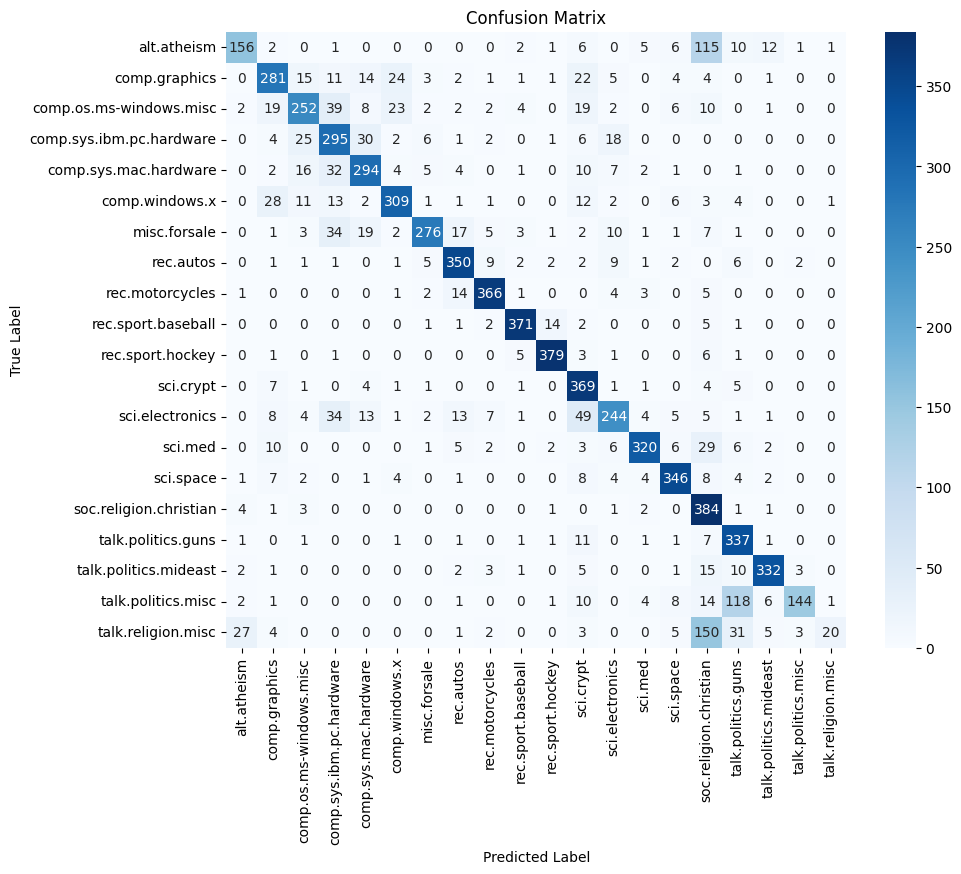


Confusion Matrix for Logistic Regression


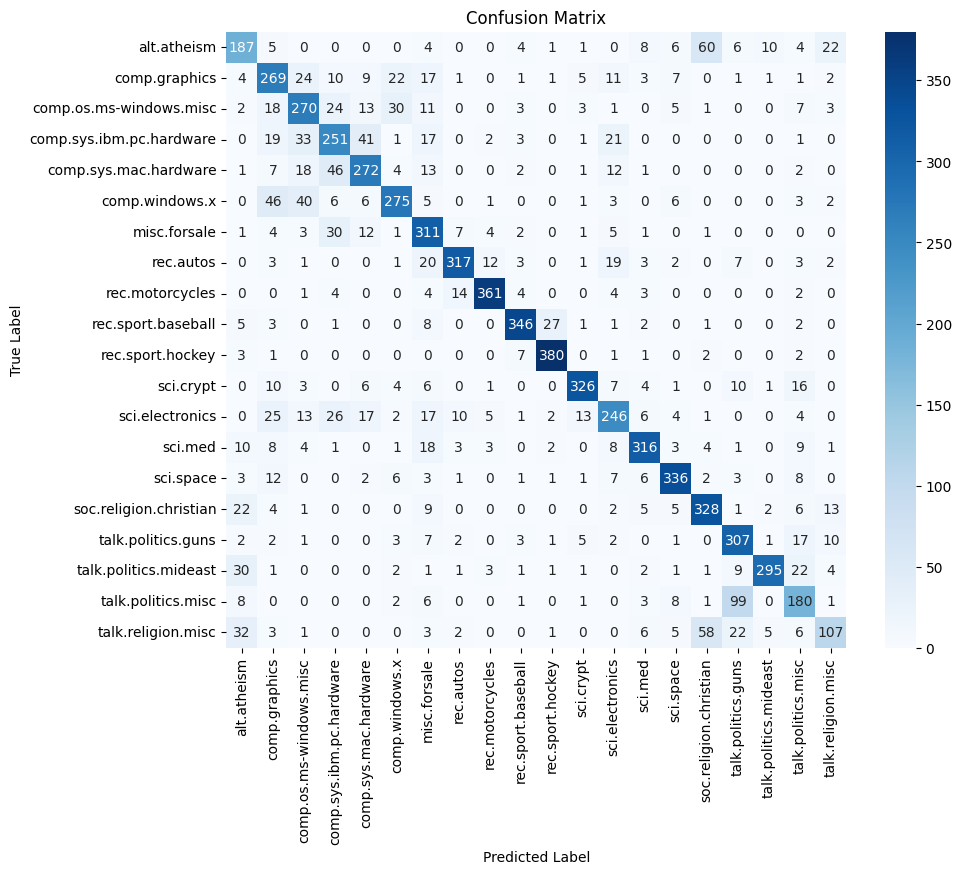


Confusion Matrix for Random Forest


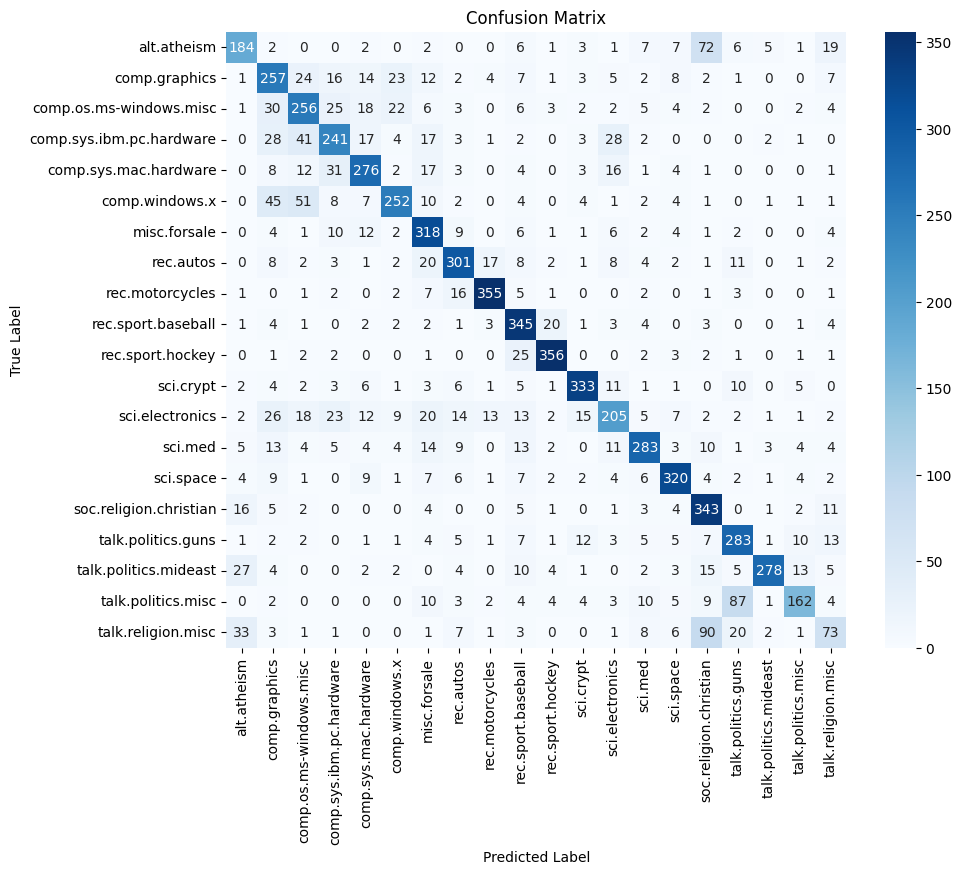

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

print("\nConfusion Matrix for Multinomial Naive Bayes")
plot_confusion_matrix(y_test, test_preds, le.classes_)

print("\nConfusion Matrix for Logistic Regression")
plot_confusion_matrix(y_test, lr_test_preds, le.classes_)

print("\nConfusion Matrix for Random Forest")
plot_confusion_matrix(y_test, rf_preds, le.classes_)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_models(models_dict, X_test, y_test):
    evaluation_summary = {}

    for model_name, model in models_dict.items():
        y_pred = model.predict(X_test)

        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Macro F1': f1_score(y_test, y_pred, average='macro'),
            'Macro Precision': precision_score(y_test, y_pred, average='macro'),
            'Macro Recall': recall_score(y_test, y_pred, average='macro'),
        }

        evaluation_summary[model_name] = metrics

    summary_df = pd.DataFrame.from_dict(evaluation_summary, orient='index')
    summary_df = summary_df.round(4)
    summary_df = summary_df.sort_values('Macro F1', ascending=False)

    return summary_df

In [ ]:
models = {
    'MultinomialNB': clf,
    'LogisticRegression': lr,
    'RandomForest': rf
}

evaluate_models(models, X_test, y_test)

,Accuracy,Macro F1,Macro Precision,Macro Recall
MultinomialNB,0.7769,0.7531,0.8079,0.7585
LogisticRegression,0.7575,0.7493,0.7572,0.7481
RandomForest,0.7230,0.7112,0.7230,0.7116


In [ ]:
import joblib

tfidf_filename = 'tfidf_vectorizer.joblib'
mnb_filename = 'multinomial_nb_model.joblib'
lr_filename = 'logistic_regression_model.joblib'
rf_filename = 'random_forest_model.joblib'

joblib.dump(best_tfidf, tfidf_filename)
print(f"TF-IDF vectorizer saved to {tfidf_filename}")

joblib.dump(clf, mnb_filename)
print(f"Multinomial Naive Bayes model saved to {mnb_filename}")

joblib.dump(lr, lr_filename)
print(f"Logistic Regression model saved to {lr_filename}")

joblib.dump(rf, rf_filename)
print(f"Random Forest model saved to {rf_filename}")


TF-IDF vectorizer saved to tfidf_vectorizer.joblib
Multinomial Naive Bayes model saved to multinomial_nb_model.joblib
Logistic Regression model saved to logistic_regression_model.joblib
Random Forest model saved to random_forest_model.joblib
